# META Gradient Boosting Model

In this notebook I build a simple end-to-end ML pipeline on daily stock data.

The goal is to:

- Download daily OHLCV data for META from Yahoo Finance
- Engineer a set of technical features (RSI, EMA, ATR, Bollinger Bands, MACD, rolling stats, lags)
- Define a forward-looking label that captures "good trades" based on a take-profit (TP) and stop-loss (SL) within a fixed horizon
- Train a Gradient Boosting classifier with time-series cross-validation
- Inspect feature importances and overall model quality
- Show how model probabilities can be turned into a simple, decision-oriented rule

This is **not** intended as a production-ready trading system.
The goal is to demonstrate how I approach:

- Feature engineering on time series
- Respecting temporal order (no leakage)
- Translating model outputs into something that can support decisions (here: a simple “enter / don’t enter” rule).

# Imports and Config

In [681]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_ta as ta

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve

# ---- config for DAILY data ----
HORIZON_BARS   = 20      # N trading days
TP             = 0.10    # +X% take profit within horizon
SL             = -0.05   # -Y% max drawdown within horizon

## 1. Data Loading

I start by pulling **daily** OHLCV data for META from Yahoo Finance using `yfinance`.

Yahoo limits how far back intraday data goes, but for daily data I can retrieve the full available history. That gives me ~10+ years of META price history, which is enough to:

- Calculate technical indicators
- Train and validate a simple ML model in a time-aware way

I also:

- Rename the columns to lower case (`open`, `high`, `low`, `close`, `volume`)
- Make sure the index is a proper `DatetimeIndex`, sorted in ascending order

In [682]:
# Download META daily data, as far back as Yahoo allows
df = yf.download(
    "META",
    interval="1d",
    period="max",
    auto_adjust=True,
    progress=False,
)

# Standardize column names
df = df.rename(
    columns={
        "Open": "open",
        "High": "high",
        "Low": "low",
        "Close": "close",
        "Volume": "volume",
    }
)

df = df.dropna().sort_index()
df.tail()

Price,close,high,low,open,volume
Ticker,META,META,META,META,META
Date,,,,,
2025-11-21,594.250000,598.119995,581.859985,588.500000,21052600
2025-11-24,613.049988,616.700012,597.630005,598.719971,23554900
2025-11-25,636.219971,637.049988,618.299988,624.000000,25213000
2025-11-26,633.609985,638.359985,631.630005,637.690002,15209500
2025-11-28,647.950012,648.049988,635.500000,636.080017,11033200


In [683]:
df.index.min(), df.index.max(), len(df)

(Timestamp('2012-05-18 00:00:00'), Timestamp('2025-11-28 00:00:00'), 3403)

### Quick sanity check: META 1d price series

Before doing any feature engineering, I like to visually check the price series to make sure the data looks sensible and continuous.

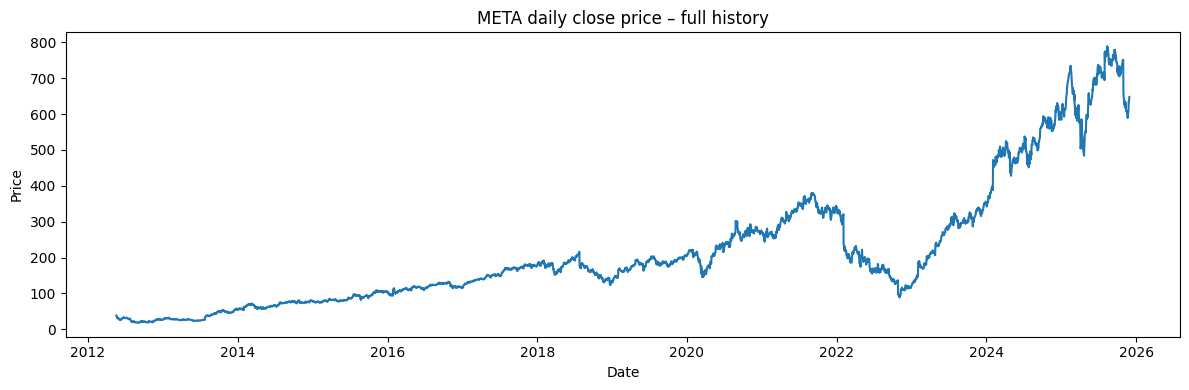

In [684]:
plt.figure(figsize=(12,4))
plt.plot(df.index, df["close"])
plt.title("META daily close price – full history")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

## 2. Feature Engineering

Here I build a modular "feature factory" that adds:

- **Technical indicators** via `pandas_ta`:
  - RSI (6, 12, 24)
  - EMA (20, 50, 100)
  - ATR (14)
  - Bollinger Bands (20)
  - MACD (12, 26, 9)
- **Rolling statistics** (mean/std/max/min) on `close` and `volume` for multiple windows
- Simple **lag features** for `close` and `volume`

This gives the model a mix of momentum, trend, volatility, and basic micro-structure information.

In [685]:
def _add_ta_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a small, opinionated bundle of TA features using pandas_ta.
    """
    # --- Momentum (RSI) ---
    df.ta.rsi(length=6, append=True)
    df.ta.rsi(length=12, append=True)
    df.ta.rsi(length=24, append=True)

    # --- Trend (EMAs) ---
    df.ta.ema(length=20, append=True)
    df.ta.ema(length=50, append=True)
    df.ta.ema(length=100, append=True)

    # --- Volatility (ATR, Bollinger Bands) ---
    df.ta.atr(length=14, append=True)
    df.ta.bbands(length=20, append=True)

    # --- MACD ---
    df.ta.macd(fast=12, slow=26, signal=9, append=True)

    return df


def _add_rolling_features(df: pd.DataFrame) -> pd.DataFrame:
    # nr of working days
    windows = [5, 20, 60, 200]  # 1w, 1m, 3m, ~1y
    cols = ["close", "volume"]

    for col in cols:
        for w in windows:
            roll = df[col].rolling(w)
            df[f"{col}_ma_{w}"] = roll.mean()
            df[f"{col}_std_{w}"] = roll.std()
            df[f"{col}_max_{w}"] = roll.max()
            df[f"{col}_min_{w}"] = roll.min()

    return df


def _add_lag_features(df: pd.DataFrame) -> pd.DataFrame:
    # lags in days
    lags = [1, 2, 5, 10, 20]
    cols = ["close", "volume"]

    for col in cols:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)

    return df


def build_features(
    df: pd.DataFrame,
    add_ta: bool = True,
    add_rolling: bool = True,
    add_lags: bool = True,
    drop_na: bool = True,
) -> pd.DataFrame:
    """
    Minimal feature factory for OHLCV data.

    Assumes:
        - df.index is DatetimeIndex
        - df has ['open','high','low','close','volume']
    """
    df = df.copy().sort_index()

    if add_ta:
        df = _add_ta_features(df)

    if add_rolling:
        df = _add_rolling_features(df)

    if add_lags:
        df = _add_lag_features(df)

    if drop_na:
        df = df.dropna()

    return df

In [686]:
ohlcv_cols = ["open", "high", "low", "close", "volume"]

df_feat = build_features(
    df[ohlcv_cols],
    add_ta=True,
    add_rolling=True,
    add_lags=True,
    drop_na=True,
)

df_feat.head(), df_feat.shape

(Price            open       high        low      close    volume close_ma_5  \
 Ticker           META       META       META       META      META              
 Date                                                                          
 2013-03-07  27.401078  28.504278  27.301690  28.404890  74540200  27.639610   
 2013-03-08  28.255812  28.295566  27.560100  27.788691  44198900  27.675389   
 2013-03-11  27.838382  28.464521  27.659485  27.967585  35642100  27.758874   
 2013-03-12  27.927835  28.146486  27.430898  27.659489  27569600  27.820494   
 2013-03-13  27.450776  27.480591  26.755064  26.914083  39619500  27.746947   
 
 Price      close_std_5 close_max_5 close_min_5 close_ma_20  ... close_lag_1  \
 Ticker                                                      ...               
 Date                                                        ...               
 2013-03-07    0.448785    28.40489   27.281816   27.688806  ...   27.281816   
 2013-03-08    0.452926    28.40489   

In [687]:
# Inspecting available data
df_feat.iloc[:5, 40:50]

Price,close_lag_10,close_lag_20,volume_lag_1,volume_lag_2,volume_lag_5,volume_lag_10,volume_lag_20
Ticker,,,,,,,
Date,,,,,,,
2013-03-07,27.112856,28.872011,33532600.0,40622200.0,83027800.0,49642300.0,38375900.0
2013-03-08,26.963778,28.474461,74540200.0,33532600.0,54064800.0,36350200.0,34540100.0
2013-03-11,27.102919,28.375074,44198900.0,74540200.0,32400700.0,34652000.0,37708800.0
2013-03-12,27.222181,28.086855,35642100.0,44198900.0,40622200.0,31611700.0,37361800.0
2013-03-13,26.705370,27.202305,27569600.0,35642100.0,33532600.0,44319700.0,93498700.0


## 3. Label definition: "good trades"

Next, I create a forward-looking label.

For each day *t* I look **20 trading days ahead** (roughly one month) and check:

- the **maximum** price reached within the next 20 days
- the **minimum** price reached within the next 20 days

From this I compute forward returns relative to today’s close:

- `max_fwd_ret` – best case within the horizon
- `min_fwd_ret` – worst case within the horizon

I then mark a day as a **"good trade"** (`good_trade = 1`) if:

- price goes up at least +5% at some point (`max_fwd_ret ≥ TP`), and
- the worst drawdown over the horizon stays better than −10% (`min_fwd_ret > SL`).

This is a simplified, horizon-based definition; it doesn’t model the exact TP/SL hit order, but it’s a reasonable proxy for “there was a clean long opportunity here”.

In [688]:
## 3. Label definition: "good trades"

# For each day t, look 20 trading days ahead and compute:
# - the minimum low in that forward window
# - the maximum high in that forward window
# Then define a "good trade" if:
#   max_fwd_ret ≥ TP and min_fwd_ret > SL.

idx = df_feat.index

# Build a clean label frame aligned to feature dates
lab = pd.DataFrame(index=idx)
lab["close"] = df.loc[idx, "close"].to_numpy()
lab["high"] = df.loc[idx, "high"].to_numpy()
lab["low"] = df.loc[idx, "low"].to_numpy()

n = len(lab)
lows = lab["low"].to_numpy()
highs = lab["high"].to_numpy()

future_min_low = np.full(n, np.nan)
future_max_high = np.full(n, np.nan)

# For each i, look at the NEXT HORIZON_BARS days: (i+1 ... i+HORIZON_BARS)
for i in range(n):
    end = i + 1 + HORIZON_BARS
    if end <= n:
        window = slice(i + 1, end)
        future_min_low[i] = lows[window].min()
        future_max_high[i] = highs[window].max()
    # else: leave as NaN (not enough future data)

lab["future_min_low"] = future_min_low
lab["future_max_high"] = future_max_high

# Forward returns relative to today's close
lab["max_fwd_ret"] = lab["future_max_high"] / lab["close"] - 1.0
lab["min_fwd_ret"] = lab["future_min_low"] / lab["close"] - 1.0

# Drop rows without full forward window
lab = lab.dropna(subset=["max_fwd_ret", "min_fwd_ret"])

# Binary label
lab["good_trade"] = (
        (lab["max_fwd_ret"] >= TP) &
        (lab["min_fwd_ret"] > SL)
).astype(int)

lab[["close", "max_fwd_ret", "min_fwd_ret", "good_trade"]].head(), lab["good_trade"].mean()

(                close  max_fwd_ret  min_fwd_ret  good_trade
 Date                                                       
 2013-03-07  28.404890     0.002099    -0.135060           0
 2013-03-08  27.788691     0.024320    -0.115880           0
 2013-03-11  27.967585     0.006397    -0.121535           0
 2013-03-12  27.659489     0.000359    -0.111750           0
 2013-03-13  26.914083     0.037666    -0.087149           0,
 np.float64(0.24277638190954773))

In [689]:
lab["good_trade"].value_counts()

good_trade
0    2411
1     773
Name: count, dtype: int64

In [690]:
# Ensure df_feat has a single level of columns (pandas_ta sometimes returns MultiIndex)
if isinstance(df_feat.columns, pd.MultiIndex):
    df_feat = df_feat.copy()
    df_feat.columns = [
        "_".join([str(level) for level in col if level not in (None, "")])
        for col in df_feat.columns.to_list()
    ]

df_feat.columns.nlevels, df_feat.columns[:10]

(1,
 Index(['open_META', 'high_META', 'low_META', 'close_META', 'volume_META',
        'close_ma_5', 'close_std_5', 'close_max_5', 'close_min_5',
        'close_ma_20'],
       dtype='object'))

In [691]:
df_model = df_feat.join(
    lab[["future_min_low", "future_max_high", "max_fwd_ret", "min_fwd_ret", "good_trade"]],
    how="inner",
)

df_model = df_model.dropna(subset=["good_trade"])

In [692]:
df_model.tail()

,open_META,high_META,low_META,close_META,volume_META,close_ma_5,close_std_5,close_max_5,close_min_5,close_ma_20,...,volume_lag_1,volume_lag_2,volume_lag_5,volume_lag_10,volume_lag_20,future_min_low,future_max_high,max_fwd_ret,min_fwd_ret,good_trade
Date,,,,,,,,,,,,,,,,,,,,,
2025-10-24,736.789978,741.210022,731.150024,738.359985,9151300,734.241992,2.395132,738.359985,732.169983,723.011002,...,9856000.0,8734500.0,12232400.0,16980100.0,9696300.0,581.25,759.159973,0.028171,-0.212782,0
2025-10-27,749.729980,755.750000,748.010010,750.820007,11321100,737.971997,7.481967,750.820007,733.270020,723.382001,...,9151300.0,9856000.0,8900200.0,9251800.0,9246800.0,581.25,759.159973,0.011108,-0.225846,0
2025-10-28,752.630005,758.400024,745.520020,751.440002,12193800,741.605994,8.904609,751.440002,733.409973,724.235001,...,11321100.0,9151300.0,7647300.0,8829800.0,16226800.0,581.25,759.159973,0.010274,-0.226485,0
2025-10-29,754.750000,759.159973,742.510010,751.669983,26818600,745.257996,8.434924,751.669983,734.000000,725.951498,...,12193800.0,11321100.0,8734500.0,10246800.0,20419600.0,581.25,680.960022,-0.094070,-0.226722,0
2025-10-30,669.150024,680.960022,650.169983,666.469971,88440100,731.751990,36.923371,751.669983,666.469971,722.922498,...,26818600.0,12193800.0,9856000.0,9017000.0,11415300.0,581.25,674.890015,0.012634,-0.127868,0


In [693]:
# Inspecting available data
df_model.iloc[:5, 40:52]

,close_lag_10,close_lag_20,volume_lag_1,volume_lag_2,volume_lag_5,volume_lag_10,volume_lag_20,future_min_low,future_max_high,max_fwd_ret,min_fwd_ret,good_trade
Date,,,,,,,,,,,,
2013-03-07,27.112856,28.872011,33532600.0,40622200.0,83027800.0,49642300.0,38375900.0,24.568538,28.464521,0.002099,-0.135060,0
2013-03-08,26.963778,28.474461,74540200.0,33532600.0,54064800.0,36350200.0,34540100.0,24.568538,28.464521,0.024320,-0.115880,0
2013-03-11,27.102919,28.375074,44198900.0,74540200.0,32400700.0,34652000.0,37708800.0,24.568538,28.146486,0.006397,-0.121535,0
2013-03-12,27.222181,28.086855,35642100.0,44198900.0,40622200.0,31611700.0,37361800.0,24.568538,27.669425,0.000359,-0.111750,0
2013-03-13,26.705370,27.202305,27569600.0,35642100.0,33532600.0,44319700.0,93498700.0,24.568538,27.927836,0.037666,-0.087149,0


## 4. Modeling dataset

At this point I have:

- `df_feat`: engineered technical features
- `lab`: forward-looking returns and `good_trade` label
- `df_model`: their inner join on the date index

Next I:
- Select all numeric feature columns
- Keep `good_trade` as the target
- Prepare `X` / `y` for modeling

In [694]:
target_col = "good_trade"

# Dropping target and redundant columns from feats
non_feature_cols = {
    target_col,
    "future_min_low",
    "future_max_high",
    "max_fwd_ret",
    "min_fwd_ret",
}

# Use all numeric columns except explicitly excluded ones
feature_cols = [
    c for c in df_model.columns
    if c not in non_feature_cols and pd.api.types.is_numeric_dtype(df_model[c])
]

len(df_model), len(feature_cols), feature_cols[:10]

(3184,
 47,
 ['open_META',
  'high_META',
  'low_META',
  'close_META',
  'volume_META',
  'close_ma_5',
  'close_std_5',
  'close_max_5',
  'close_min_5',
  'close_ma_20'])

In [695]:
# Chronological order is critical for time-series CV
df_model = df_model.sort_index()

X = df_model[feature_cols].values
y = df_model[target_col].astype(int).values

print("Rows:", X.shape[0])
print("Features:", X.shape[1])
print("Share of good trades:", y.mean().round(3))

Rows: 3184
Features: 47
Share of good trades: 0.243


## 5. Gradient Boosting with time-series CV

I use a `GradientBoostingClassifier` and `TimeSeriesSplit` to respect the temporal structure.

For each fold:

- Train on the **past**
- Evaluate on a **future** segment
- Store predicted probabilities for `good_trade = 1`

This gives an honest, walk-forward estimate of model performance and probabilities.

In [696]:
tscv = TimeSeriesSplit(n_splits=5)

proba_all = np.full(len(df_model), np.nan)
pred_all  = np.full(len(df_model), np.nan)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    # --- train metrics ---
    y_train_proba = clf.predict_proba(X_train)[:, 1]
    y_train_pred  = clf.predict(X_train)
    train_auc     = roc_auc_score(y_train, y_train_proba)

    # --- test metrics (out-of-sample for this fold) ---
    y_test_proba = clf.predict_proba(X_test)[:, 1]
    y_test_pred  = clf.predict(X_test)
    try:
        test_auc = roc_auc_score(y_test, y_test_proba)
    except ValueError:
        test_auc = np.nan

    pred_all[test_idx]  = y_test_pred
    proba_all[test_idx] = y_test_proba

    print(f"\n=== Fold {fold} ===")
    print(f"Train ROC AUC: {train_auc:.4f}")
    print(f"Test  ROC AUC: {test_auc:.4f}")
    print(classification_report(y_test, y_test_pred, digits=3))


=== Fold 1 ===
Train ROC AUC: 1.0000
Test  ROC AUC: 0.5263
              precision    recall  f1-score   support

           0      0.835     0.980     0.902       444
           1      0.000     0.000     0.000        86

    accuracy                          0.821       530
   macro avg      0.417     0.490     0.451       530
weighted avg      0.699     0.821     0.755       530


=== Fold 2 ===
Train ROC AUC: 0.9990
Test  ROC AUC: 0.3734
              precision    recall  f1-score   support

           0      0.830     0.998     0.906       440
           1      0.000     0.000     0.000        90

    accuracy                          0.828       530
   macro avg      0.415     0.499     0.453       530
weighted avg      0.689     0.828     0.752       530


=== Fold 3 ===
Train ROC AUC: 0.9955
Test  ROC AUC: 0.4292
              precision    recall  f1-score   support

           0      0.755     0.818     0.785       407
           1      0.169     0.122     0.142       123

  

The cross-validated performance is modest: ROC AUC is in the ~0.55–0.64 range,
and the model is quite conservative on 'good trades' (class 1), with low recall.

This is not surprising given:
- A single stock (META) with a fairly noisy label (TP/SL hit somewhere in the next 20 days)
- No macro or cross-sectional information
- A small, tree-based model without hyperparameter tuning

For the purposes of this notebook, I’m more interested in demonstrating a clean, time-aware ML workflow
than in squeezing maximum alpha out of this setup.

In [697]:
df_model["proba"] = proba_all
df_model["pred"] = pred_all

df_model = df_model.dropna(subset=["proba"])
df_model[["good_trade", "proba"]].tail()

,good_trade,proba
Date,,
2025-10-24,0,0.577173
2025-10-27,0,0.601867
2025-10-28,0,0.490956
2025-10-29,0,0.812685
2025-10-30,0,0.381771


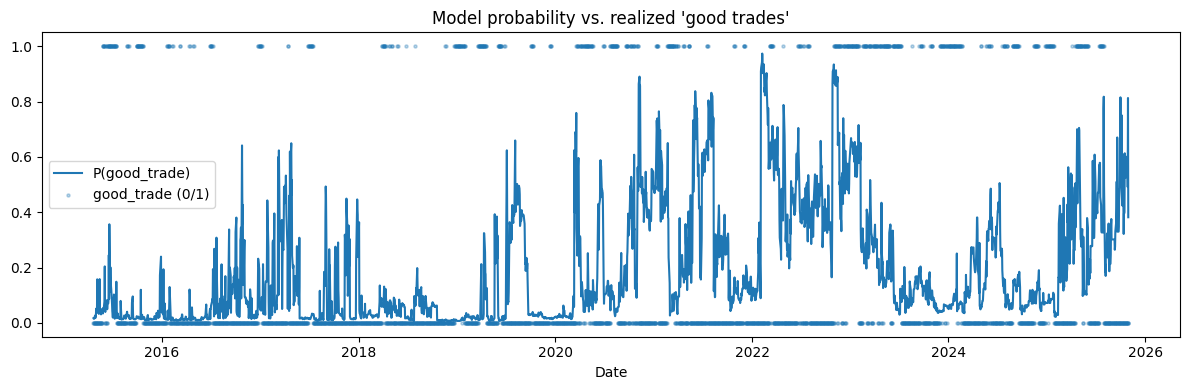

In [698]:
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, df_model["proba"], label="P(good_trade)")
plt.scatter(
    df_model.index, df_model["good_trade"],
    s=5, alpha=0.3, label="good_trade (0/1)"
)
plt.title("Model probability vs. realized 'good trades'")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

## 5a. Overall out-of-sample ROC curve

Using the cross-validated probabilities, I can compute a single,
global ROC curve and AUC that summarise performance across all folds.

This treats each test fold as a small out-of-sample slice and then
stitches them together into one evaluation.

In [699]:
# Mask out the rows that were never in a test fold (should be few at the very start)
mask = ~np.isnan(proba_all)
y_oos = y[mask]
proba_oos = proba_all[mask]

overall_auc = roc_auc_score(y_oos, proba_oos)
fpr, tpr, thresholds = roc_curve(y_oos, proba_oos)

print(f"Overall out-of-sample ROC AUC: {overall_auc:.4f}")

Overall out-of-sample ROC AUC: 0.5272


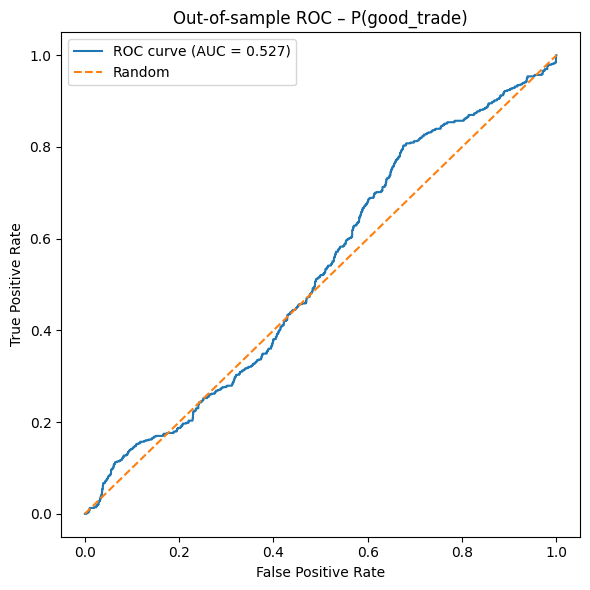

In [700]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {overall_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Out-of-sample ROC – P(good_trade)")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Feature importance

To understand what the model is using, I fit a Gradient Boosting classifier
on the full dataset and inspect the feature importances.

In [701]:
final_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
)
final_clf.fit(X, y)

feat_imp = (
    pd.Series(final_clf.feature_importances_, index=feature_cols)
    .sort_values(ascending=False)
    .to_frame("importance")
)

feat_imp.head(20)

,importance
close_std_200,0.125824
volume_max_200,0.071009
volume_min_60,0.061034
close_std_60,0.058443
volume_std_60,0.054614
volume_std_200,0.039375
close_ma_200,0.038621
volume_min_20,0.038411
volume_ma_200,0.037157
volume_ma_60,0.030958


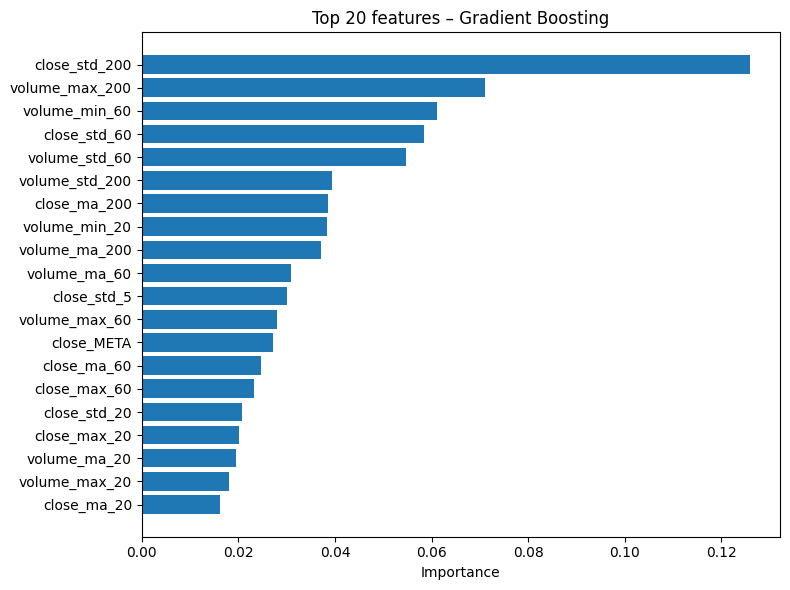

In [702]:
top_n = 20
top = feat_imp.head(top_n).iloc[::-1]

plt.figure(figsize=(8, 6))
plt.barh(top.index, top["importance"])
plt.title(f"Top {top_n} features – Gradient Boosting")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## 6a. Simple probability-based entry rule

Finally, I define a simple rule:

> **Enter** when `P(good_trade) ≥ 0.6`.

I then compare the "hit rate" (share of `good_trade = 1`) among the selected days
to the unconditional base rate in the dataset.

This aim is to shows whether the model can meaningfully
tilt the odds towards better setups.

In [703]:
PROBA_THRESHOLD = 0.50

df_model["signal_long"] = (df_model["proba"] >= PROBA_THRESHOLD).astype(int)

base_rate = df_model["good_trade"].mean()
signal_mask = df_model["signal_long"] == 1

signal_rate = df_model.loc[signal_mask, "good_trade"].mean()
num_signals = signal_mask.sum()

print(f"Base rate of good trades               : {base_rate:.3f}")
print(f"Signal rate (proba >= {PROBA_THRESHOLD:.2f}) : {signal_rate:.3f}")
print(f"Number of signals                      : {num_signals}")

Base rate of good trades               : 0.238
Signal rate (proba >= 0.50) : 0.314
Number of signals                      : 274


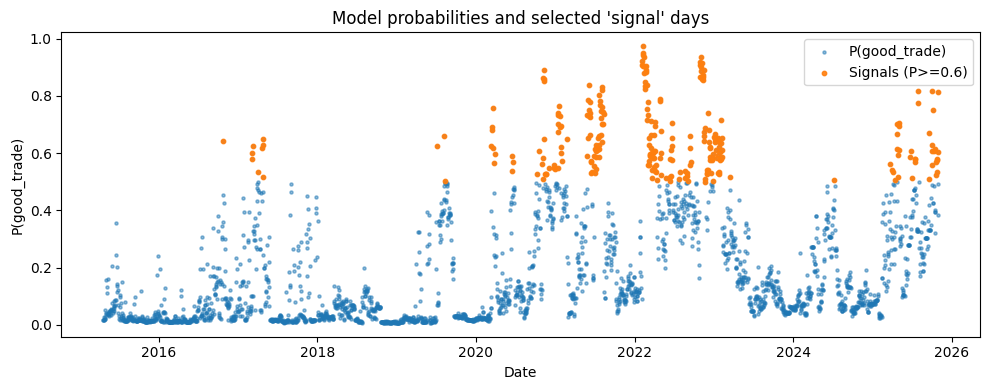

In [704]:
plt.figure(figsize=(10, 4))
plt.scatter(
    df_model.index, df_model["proba"],
    s=5, alpha=0.5, label="P(good_trade)"
)
plt.scatter(
    df_model.index[df_model["signal_long"] == 1],
    df_model.loc[df_model["signal_long"] == 1, "proba"],
    s=10, alpha=0.9, label="Signals (P>=0.6)"
)
plt.title("Model probabilities and selected 'signal' days")
plt.xlabel("Date")
plt.ylabel("P(good_trade)")
plt.legend()
plt.tight_layout()
plt.show()

### 6b. In-sample ROC for the final model (optimistic)

For reference, I also look at the in-sample ROC AUC of the final model
trained on all data. This is an upper bound: it reflects how well the
model fits the past, not how well it generalises. The more relevant
number is the out-of-sample AUC from the time-series CV above.

In [705]:
proba_train_full = final_clf.predict_proba(X)[:, 1]
train_full_auc = roc_auc_score(y, proba_train_full)

print(f"In-sample ROC AUC (full training data): {train_full_auc:.4f}")

In-sample ROC AUC (full training data): 0.9845


## 7. Simple equity curve vs. buy & hold

Here I convert the probability-based signal into a daily long/flat position:

- If `P(good_trade) ≥ 0.6` on day *t*, I go long on day *t+1*.
- Otherwise I stay flat.

Then I:

- Compute daily returns for META
- Apply the position to get strategy returns
- Compare the resulting equity curve to a buy & hold benchmark starting from 10,000 USD.

In [706]:

START_CAPITAL = 10_000

df_bt = df_model.copy().sort_index()

# If your price column is "close" instead of "close_META", change this line:
price_col = "close_META"  # or "close" depending on your df_model

# 1) Daily returns
df_bt["ret"] = df_bt[price_col].pct_change().fillna(0.0)

# 2) Position: use yesterday's signal for today's position (no look-ahead)
#    If signal_long[t] == 1, we are long on day t+1.
df_bt["position"] = df_bt["signal_long"].shift(1).fillna(0.0)

# 3) Strategy returns = position * daily returns
df_bt["strategy_ret"] = df_bt["position"] * df_bt["ret"]

# 4) Equity curves
df_bt["equity_buy_hold"] = START_CAPITAL * (1 + df_bt["ret"]).cumprod()
df_bt["equity_strategy"] = START_CAPITAL * (1 + df_bt["strategy_ret"]).cumprod()

# 5) Final numbers
final_strat = df_bt["equity_strategy"].iloc[-1]
final_bh = df_bt["equity_buy_hold"].iloc[-1]

print(f"Final equity – strategy   : {final_strat:,.2f} USD")
print(f"Final equity – buy & hold : {final_bh:,.2f} USD")
print(f"Total return – strategy   : {final_strat / START_CAPITAL - 1:.2%}")
print(f"Total return – buy & hold : {final_bh / START_CAPITAL - 1:.2%}")

Final equity – strategy   : 31,326.67 USD
Final equity – buy & hold : 80,193.56 USD
Total return – strategy   : 213.27%
Total return – buy & hold : 701.94%


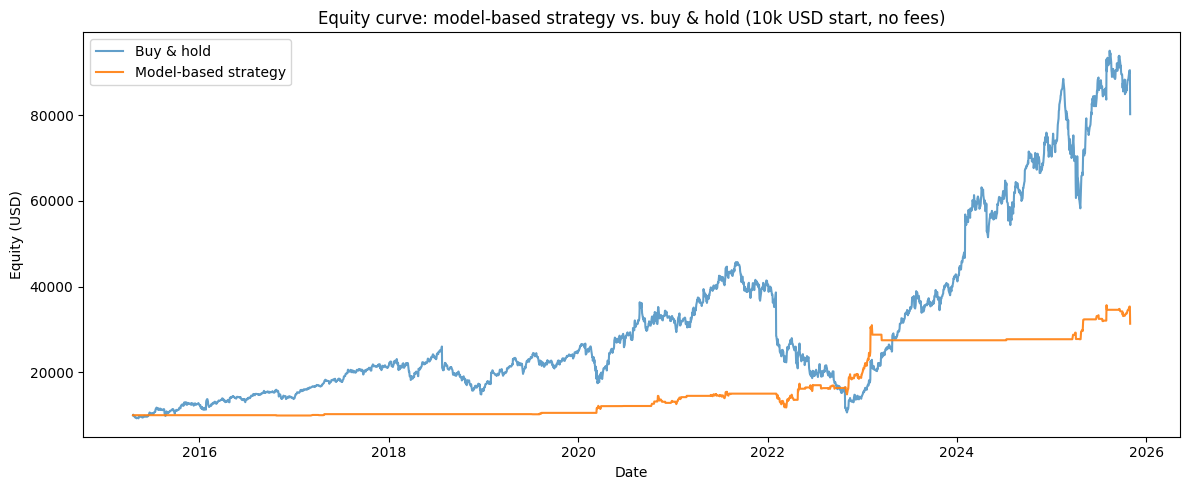

In [707]:
plt.figure(figsize=(12, 5))
plt.plot(df_bt.index, df_bt["equity_buy_hold"], label="Buy & hold", alpha=0.7)
plt.plot(df_bt.index, df_bt["equity_strategy"], label="Model-based strategy", alpha=0.9)
plt.title("Equity curve: model-based strategy vs. buy & hold (10k USD start, no fees)")
plt.xlabel("Date")
plt.ylabel("Equity (USD)")
plt.legend()
plt.tight_layout()
plt.show()

## 8. Takeaways

This notebook is deliberately simple, but it covers the full loop:

- Start from raw daily OHLCV data (META)
- Engineer a rich but interpretable feature set (RSI, EMA, ATR, Bollinger Bands, MACD, rolling stats, lags)
- Define a forward-looking label that approximates “good long opportunities” given a TP/SL template
- Use time-aware cross-validation to avoid leakage
- Interpret the model via feature importance
- Translate probabilities into a simple rule and compare it to the base rate

In a production setting I would:
- Stress-test the label definition and thresholds
- Add proper transaction cost modeling and position sizing
- Run a full backtest including overlapping trades and risk management

Here the aim is to show the structure of my workflow rather than to propose a ready-to-trade strategy.